<a href="https://colab.research.google.com/github/ximeeb/ebertz-gross-lopez-tp-lcs/blob/master/malignant_vs_benign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets
!pip install pandas

In [ ]:
import tensorflow as tf
import numpy as np
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from pandas.io.formats.info import DataFrameTableBuilder
import opendatasets as od
import pandas
import cv2
import os
import matplotlib.pyplot as plt
import json
from PIL import Image
import shutil
import random
import math

Como el dataset `skin-cancer-malignant-vs-benign`
no arrojó los resultados esperados en el ámbito de prueba, lo complementamos con el dataset `isic-2019`.



In [ ]:
od.download("https://www.kaggle.com/datasets/fanconic/skin-cancer-malignant-vs-benign")

In [ ]:
od.download("https://www.kaggle.com/datasets/andrewmvd/isic-2019")

Debido a la gran cantidad de imágenes pertenecientes a `isic-2019` y el desbalance entre ellas, determinamos que la lectura de dos mil imágenes extra por clase son suficientes para nuestro problema.

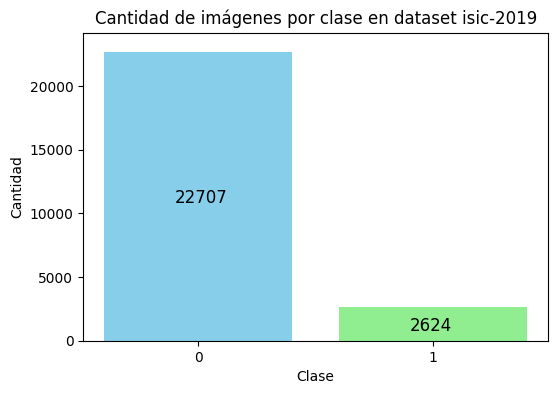

In [ ]:
datos = pandas.read_csv("/content/isic-2019/ISIC_2019_Training_GroundTruth.csv")
etiquetas = datos["BKL"]

cant_0 = (etiquetas == 0).sum()
cant_1 = (etiquetas == 1).sum()

categorias = ['0', '1']
cantidades = [cant_0, cant_1]

plt.figure(figsize=(6, 4))
barras = plt.bar(categorias, cantidades, color=['skyblue', 'lightgreen'])

for bar, cantidad in zip(barras, cantidades):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() / 2 - 550, str(cantidad), fontsize=12)

plt.xlabel('Clase')
plt.ylabel('Cantidad')
plt.title('Cantidad de imágenes por clase en dataset isic-2019')
plt.ylim(0, max(cantidades) + 1500)

plt.show()

In [ ]:
ruta_test = "/content/skin-cancer-malignant-vs-benign/test"
ruta_train = "/content/skin-cancer-malignant-vs-benign/train"

In [ ]:
def distancia_a_maximo(arr):
  index_min = arr.index(min(arr))
  index_max = arr.index(max(arr))

  arr[index_min] = max(arr) - min(arr)
  arr[index_max] = 0

In [ ]:
cant_imgs_train_benign = len(os.listdir(ruta_train + "/benign"))
cant_imgs_train_malignant = len(os.listdir(ruta_train + "/malignant"))

cant_imgs_test_benign = len(os.listdir(ruta_test + "/benign"))
cant_imgs_test_malignant = len(os.listdir(ruta_test + "/malignant"))

cant_train = [cant_imgs_train_malignant, cant_imgs_train_benign]
cant_test = [cant_imgs_test_malignant, cant_imgs_test_benign]

distancia_a_maximo(cant_train)
distancia_a_maximo(cant_test)

In [ ]:
print(cant_train)
print(cant_test)

[243, 0]
[60, 0]


In [ ]:
datos = pandas.read_csv("/content/isic-2019/ISIC_2019_Training_GroundTruth.csv")

cant_imgs = 2000
et_0_train = datos[datos.BKL == 0][:cant_imgs + cant_train[0]]
et_1_train = datos[datos.BKL == 1][:cant_imgs + cant_train[1]]

et_0_test = datos[datos.BKL == 0][cant_imgs + cant_test[0]: cant_imgs + cant_test[0] + 300]
et_1_test = datos[datos.BKL == 1][cant_imgs + cant_test[1]: cant_imgs + cant_test[1] + 300]

datos = et_0_train.merge(et_1_train, how = 'outer')
datos = datos.sort_values(by="image", ascending=True)
datos = datos[["image", "BKL"]]

test = et_0_test.merge(et_1_test, how = 'outer')
test = test.sort_values(by="image", ascending=True)
test = test[["image", "BKL"]]

datos

,image,BKL
0,ISIC_0000000,0.0
1,ISIC_0000001,0.0
2,ISIC_0000002,0.0
3,ISIC_0000003,0.0
4,ISIC_0000004,0.0
...,...,...
4238,ISIC_0062371,1.0
4239,ISIC_0062374,1.0
4240,ISIC_0062379,1.0
4241,ISIC_0062411,1.0


Para contar con todas las imágenes en un mismo directorio, las copiamos de `isic` hacia `skin-cancer-malignant-vs-benign`.

Esto facilitó la lectura de las imágenes, ya que las imágenes no están fisicamente separada, por lo que no se deben hacer pasos extra de lectura.

In [ ]:
def copiar_imagenes_segun_etiqueta(datos, col_etiqueta, ruta_inicio, ruta_fin):
  for i in range(len(datos)):
    image_path = ruta_inicio + datos["image"][i] + ".jpg"
    etiqueta = datos[col_etiqueta][i]

    copy_path = ruta_fin + "/malignant" if etiqueta == 0.0 else ruta_fin + "/benign"
    shutil.copy(image_path, copy_path)

In [ ]:
ruta_images = "/content/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/"
copiar_imagenes_segun_etiqueta(datos, "BKL", ruta_images, ruta_train)
copiar_imagenes_segun_etiqueta(test, "BKL", ruta_images, ruta_test)

In [ ]:
for i in range(len(test)):
    image_path = "/content/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/" + datos["image"][i] + ".jpg"
    etiqueta = datos["BKL"][i]

    copy_path = ruta_test + "/malignant" if etiqueta == 0.0 else ruta_test + "/benign"
    shutil.copy(image_path, copy_path)

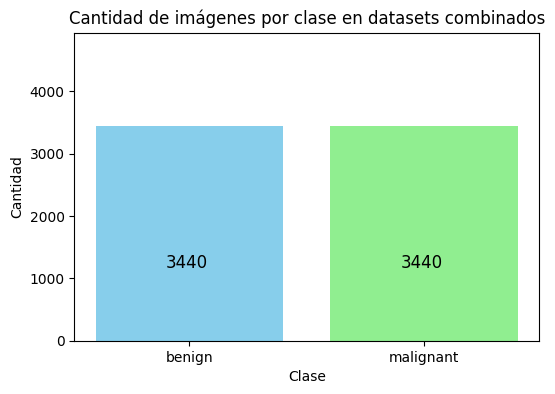

In [ ]:
cant_imgs_benign = len(os.listdir(ruta_train + "/benign"))
cant_imgs_malignant = len(os.listdir(ruta_train + "/malignant"))

categorias = ['benign', 'malignant']
cantidades = [cant_imgs_benign, cant_imgs_malignant]

plt.figure(figsize=(6, 4))
barras = plt.bar(categorias, cantidades, color=['skyblue', 'lightgreen'])

for bar, cantidad in zip(barras, cantidades):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() / 2 - 550, str(cantidad), fontsize=12)

plt.xlabel('Clase')
plt.ylabel('Cantidad')
plt.title('Cantidad de imágenes por clase en datasets combinados')
plt.ylim(0, max(cantidades) + 1500)

plt.show()

In [ ]:
def cargar_imagenes_y_etiquetas(ruta_carpeta):
  imagenes_benign, etiquetas_benign = cargar_imagenes(ruta_carpeta + "/benign", 0)
  imagenes_malignant, etiquetas_malignant = cargar_imagenes(ruta_carpeta + "/malignant", 1)

  imagenes = imagenes_benign + imagenes_malignant
  etiquetas = etiquetas_benign + etiquetas_malignant

  imagenes, etiquetas = mezclar_con_correspondencia(imagenes, etiquetas)
  return imagenes, etiquetas

In [ ]:
def cargar_imagenes(ruta_carpeta, etiqueta):
    archivos_img = os.listdir(ruta_carpeta)

    imagenes = []
    etiquetas = []
    tamano_img = 100

    for archivo_img in archivos_img:
        if es_imagen(archivo_img):
            ruta_imagen = os.path.join(ruta_carpeta, archivo_img)
            imagen = leer_imagen(ruta_imagen, tamano_img)

            imagenes.append(imagen)
            etiquetas.append(etiqueta)

    return imagenes, etiquetas

In [ ]:
def mezclar_con_correspondencia(imagenes, etiquetas):
  combinados = list(zip(imagenes, etiquetas))
  random.shuffle(combinados)
  i, e = zip(*combinados)
  return i, e

In [ ]:
def es_imagen(archivo):
  return archivo.endswith('.jpg') or archivo.endswith('.png')

In [ ]:
def leer_imagen(ruta, tamano):
  imagen = cv2.imread(ruta, cv2.COLOR_BGR2RGB)
  imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
  imagen = np.array(cv2.resize(imagen, (tamano, tamano)))

  return imagen

In [ ]:
imagenes_entrenamiento, etiquetas_entrenamiento = cargar_imagenes_y_etiquetas(ruta_train)
imagenes_prueba, etiquetas_prueba = cargar_imagenes_y_etiquetas(ruta_test)

In [ ]:
print(len(imagenes_entrenamiento), len(etiquetas_entrenamiento))
print(len(imagenes_prueba), len(etiquetas_prueba))

6880 6880
1860 1860


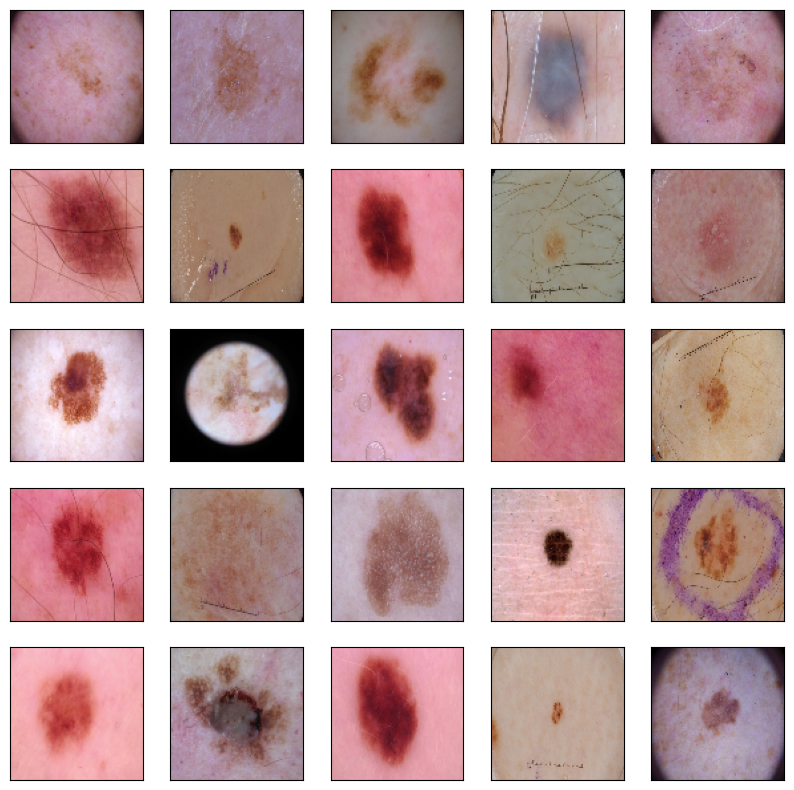

In [ ]:
# Mostrar algunas imágenes
plt.figure(figsize = (10, 10))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(imagenes_entrenamiento[i])

plt.show()

La red neuronal toma como entrada matrices multidimensionales llamadas *tensores*. Por lo tanto, como paso previo, se debe convertir las imágenes y las etiquetas a este formato.

También, utilizamos *normalización*, que consiste en dividir cada pixel de la imagen por 255, para que todos los pixeles estén en el rango [0, 1]. Esto mejora el rendimiento y aprendizaje de la IA.

In [ ]:
# Normalización de entradas y conversión de listas a tensores
imagenes_entrenamiento = np.array(imagenes_entrenamiento).astype(float) / 255
imagenes_prueba = np.array(imagenes_prueba).astype(float) / 255

etiquetas_entrenamiento = np.array(etiquetas_entrenamiento)
etiquetas_prueba = np.array(etiquetas_prueba)

Con la finalidad de comparar resultados, definimos tres modelos:

*   Modelo Denso
*   Modelo Convolucional
*   Modelo Convolucional, con aumento de datos



In [ ]:
modelo_denso = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape = (100, 100, 3)),
    tf.keras.layers.Dense(150, activation = 'relu'),
    tf.keras.layers.Dense(150, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid'),
])

#Compilación
modelo_denso.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
modelo_cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', input_shape = (100, 100, 3)),
    tf.keras.layers.MaxPooling2D(3, 3),
    tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', input_shape = (100, 100, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

#Compilación
modelo_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Preparación de generador de datos
generador_datos = ImageDataGenerator (
    rotation_range = 50, # Rotación aleatoria de las imágenes
    width_shift_range = 0.1, # Movimiento hacia los lados
    height_shift_range = 0.1, # Movimiento hacia arriba o abajo
    shear_range = 15, # Inclinación
    zoom_range = [0.9, 1.0],
    horizontal_flip = True,
    vertical_flip = True
)

generador_datos.fit(imagenes_entrenamiento)

In [ ]:
modelo_cnn_ad = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', input_shape = (100, 100, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),


    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(150, activation = 'relu'),
    tf.keras.layers.Dense(150, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

#Compilación
modelo_cnn_ad.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

generador_datos_entrenamiento = generador_datos.flow(imagenes_entrenamiento, etiquetas_entrenamiento, batch_size = 32)

El entrenamiento de cada modelo se completará en veinte vueltas.

In [ ]:
epocas = 20

In [ ]:
print("Entrenando modelo denso...")
historial_denso = modelo_denso.fit(imagenes_entrenamiento, etiquetas_entrenamiento, epochs=epocas, validation_data=(imagenes_prueba, etiquetas_prueba), use_multiprocessing=True, shuffle=True)
print("Modelo denso entrenado!")

Entrenando modelo denso...
Epoch 1/20
215/215 [==============================] - 16s 68ms/step - loss: 0.9754 - accuracy: 0.5985 - val_loss: 0.7707 - val_accuracy: 0.4651
Epoch 2/20
215/215 [==============================] - 14s 66ms/step - loss: 0.5879 - accuracy: 0.7032 - val_loss: 0.6616 - val_accuracy: 0.6328
Epoch 3/20
215/215 [==============================] - 14s 65ms/step - loss: 0.5740 - accuracy: 0.7167 - val_loss: 0.5105 - val_accuracy: 0.7785
Epoch 4/20
215/215 [==============================] - 14s 65ms/step - loss: 0.5535 - accuracy: 0.7227 - val_loss: 0.5189 - val_accuracy: 0.7581
Epoch 5/20
215/215 [==============================] - 15s 69ms/step - loss: 0.5484 - accuracy: 0.7317 - val_loss: 0.5082 - val_accuracy: 0.7688
Epoch 6/20
215/215 [==============================] - 15s 70ms/step - loss: 0.5720 - accuracy: 0.7163 - val_loss: 0.5446 - val_accuracy: 0.7355
Epoch 7/20
215/215 [==============================] - 16s 73ms/step - loss: 0.5616 - accuracy: 0.7224 - val_l

In [ ]:
print("Entrenando modelo convolucional...")
historial_cnn = modelo_cnn.fit(imagenes_entrenamiento, etiquetas_entrenamiento, epochs=epocas, validation_data=(imagenes_prueba, etiquetas_prueba), use_multiprocessing=True, shuffle=True)
print("Modelo convolucional entrenado!")

Entrenando modelo convolucional...
Epoch 1/20
215/215 [==============================] - 42s 189ms/step - loss: 0.6083 - accuracy: 0.6722 - val_loss: 0.5461 - val_accuracy: 0.7608
Epoch 2/20
215/215 [==============================] - 42s 195ms/step - loss: 0.5360 - accuracy: 0.7519 - val_loss: 0.5445 - val_accuracy: 0.7441
Epoch 3/20
215/215 [==============================] - 42s 195ms/step - loss: 0.5171 - accuracy: 0.7658 - val_loss: 0.4721 - val_accuracy: 0.7833
Epoch 4/20
215/215 [==============================] - 44s 204ms/step - loss: 0.4923 - accuracy: 0.7741 - val_loss: 0.3976 - val_accuracy: 0.8231
Epoch 5/20
215/215 [==============================] - 43s 200ms/step - loss: 0.4778 - accuracy: 0.7871 - val_loss: 0.4068 - val_accuracy: 0.8231
Epoch 6/20
215/215 [==============================] - 42s 198ms/step - loss: 0.4690 - accuracy: 0.7872 - val_loss: 0.3638 - val_accuracy: 0.8376
Epoch 7/20
215/215 [==============================] - 43s 198ms/step - loss: 0.4525 - accuracy:

In [ ]:
print("Entrenando modelo convolucional con aumento de datos...")
historial_cnn_ad = modelo_cnn_ad.fit(
    generador_datos_entrenamiento,
    epochs=epocas,
    validation_data=(imagenes_prueba, etiquetas_prueba),
    use_multiprocessing=True,
    shuffle=True
)
print("Modelo convolucional con aumento de datos entrenado!")

Entrenando modelo convolucional con aumento de datos...
Epoch 1/20
215/215 [==============================] - 81s 358ms/step - loss: 0.5869 - accuracy: 0.6894 - val_loss: 0.4673 - val_accuracy: 0.7694
Epoch 2/20
215/215 [==============================] - 78s 361ms/step - loss: 0.5125 - accuracy: 0.7477 - val_loss: 0.4372 - val_accuracy: 0.7860
Epoch 3/20
215/215 [==============================] - 77s 356ms/step - loss: 0.5078 - accuracy: 0.7512 - val_loss: 0.4318 - val_accuracy: 0.7839
Epoch 4/20
215/215 [==============================] - 82s 378ms/step - loss: 0.4960 - accuracy: 0.7564 - val_loss: 0.3975 - val_accuracy: 0.8086
Epoch 5/20
215/215 [==============================] - 79s 364ms/step - loss: 0.4989 - accuracy: 0.7539 - val_loss: 0.4033 - val_accuracy: 0.8172
Epoch 6/20
215/215 [==============================] - 76s 351ms/step - loss: 0.4755 - accuracy: 0.7757 - val_loss: 0.4486 - val_accuracy: 0.7941
Epoch 7/20
215/215 [==============================] - 81s 373ms/step - los

La precisión y el nivel de error de cada modelo se puede ver en las siguientes gráficas:

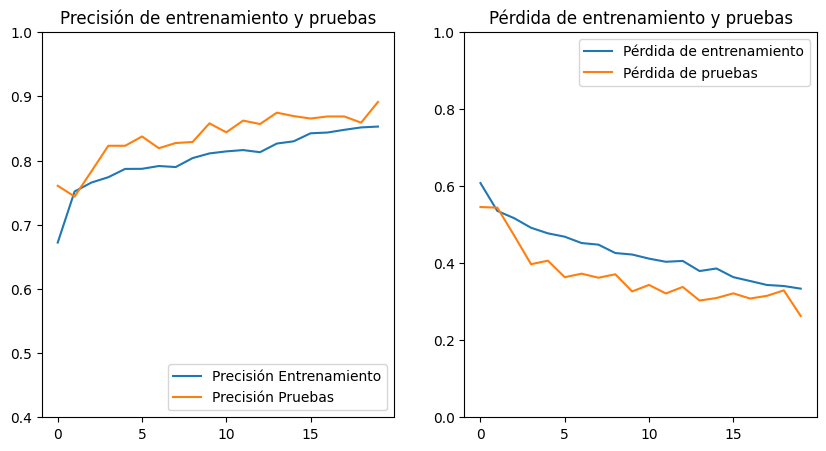

In [ ]:
# Graficas de precisión y pérdida de modelo
acc = historial_cnn.history['accuracy']
val_acc = historial_cnn.history['val_accuracy']

loss = historial_cnn.history['loss']
val_loss = historial_cnn.history['val_loss']

rango_epocas = range(epocas)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(rango_epocas, acc, label='Precisión Entrenamiento')
plt.plot(rango_epocas, val_acc, label='Precisión Pruebas')
plt.legend(loc='lower right')
plt.ylim(0.4, 1)
plt.title('Precisión de entrenamiento y pruebas')

plt.subplot(1,2,2)
plt.plot(rango_epocas, loss, label= 'Pérdida de entrenamiento')
plt.plot(rango_epocas, val_loss, label='Pérdida de pruebas')
plt.legend(loc='upper right')
plt.ylim(0, 1)
plt.title('Pérdida de entrenamiento y pruebas')
plt.show()

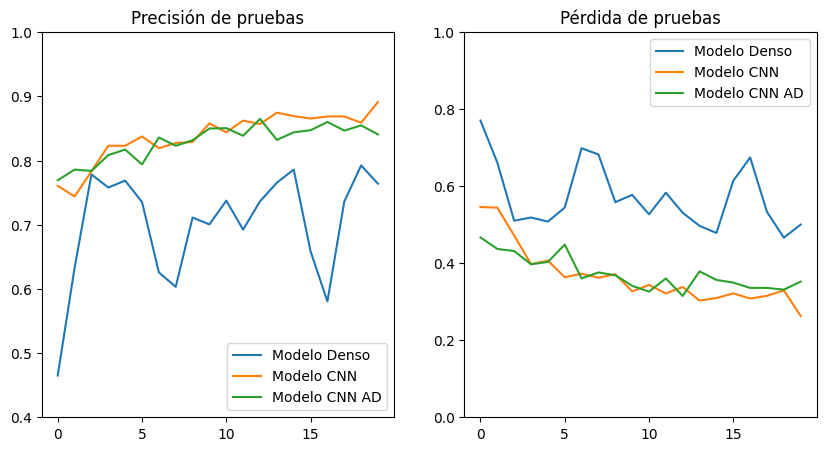

In [ ]:
# Graficas de precisión y pérdida de todos los modelos
acc_denso = historial_denso.history['val_accuracy']
acc_cnn = historial_cnn.history['val_accuracy']
acc_cnn_ad = historial_cnn_ad.history['val_accuracy']

loss_denso = historial_denso.history['val_loss']
loss_cnn = historial_cnn.history['val_loss']
loss_cnn_ad = historial_cnn_ad.history['val_loss']

rango_epocas = range(epocas)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(rango_epocas, acc_denso, label='Modelo Denso')
plt.plot(rango_epocas, acc_cnn, label='Modelo CNN')
plt.plot(rango_epocas, acc_cnn_ad, label='Modelo CNN AD')
plt.legend(loc='lower right')
plt.ylim(0.4, 1)
plt.title('Precisión de pruebas')

plt.subplot(1,2,2)
plt.plot(rango_epocas, loss_denso, label='Modelo Denso')
plt.plot(rango_epocas, loss_cnn, label='Modelo CNN')
plt.plot(rango_epocas, loss_cnn_ad, label='Modelo CNN AD')
plt.legend(loc='upper right')
plt.ylim(0, 1)
plt.title('Pérdida de pruebas')
plt.show()

Finalmente, realizamos una prueba para comparar resultados.

In [ ]:
def prediccion_es_correcta(esperado, prediccion):
    return round(prediccion[0]) == esperado

In [ ]:
def imprimir_testing(predicciones, etiquetas_esperadas, cant_imagenes):
    correctas_tipo = [0, 0]
    falladas_tipo = [0, 0]

    print("Predicciones:", len(predicciones))

    for i in range(cant_imagenes):
      prediccion = predicciones[i]
      esperado = etiquetas_esperadas[i]

      if prediccion_es_correcta(esperado, prediccion):
        correctas_tipo[esperado] += 1
      else:
        falladas_tipo[esperado] += 1

    print("Tipo 0:", correctas_tipo[0], "correctas,", falladas_tipo[0], "incorrectas")
    print("Tipo 1:", correctas_tipo[1], "correctas,", falladas_tipo[1], "incorrectas")

    total_correctas = correctas_tipo[0] + correctas_tipo[1]
    print("Total:", total_correctas, "correctas,", cant_imagenes - total_correctas, "incorrectas\n")

In [ ]:
# Testing
imagenes = np.array(imagenes_prueba)

print("Predicciones del modelo denso")
imprimir_testing(modelo_denso.predict(imagenes), etiquetas_prueba, len(imagenes))

print("Predicciones del modelo convolutivo")
imprimir_testing(modelo_cnn.predict(imagenes), etiquetas_prueba, len(imagenes))

print("Predicciones del modelo convolutivo con aumento de datos")
imprimir_testing(modelo_cnn_ad.predict(imagenes), etiquetas_prueba, len(imagenes))

Predicciones del modelo convolutivo
59/59 [==============================] - 3s 56ms/step
Predicciones: 1860
Tipo 0: 550 correctas, 110 incorrectas
Tipo 1: 1108 correctas, 92 incorrectas
Total: 1658 correctas, 202 incorrectas



Como podemos ver, el modelo convolutivo sin aumento de datos fue el que mejor predicciones logró.

Este será el utilizado para subir a la nube.

In [ ]:
# Exportación del modelo en formato h5
modelo_cnn.save("deteccion-lunares-cnn.h5")

In [ ]:
!pip install tensorflowjs

In [ ]:
!mkdir carpeta_salida

In [ ]:
!tensorflowjs_converter --input_format keras deteccion-lunares-cnn.h5 carpeta_salida

2023-09-04 04:39:50.715077: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
